In [1]:
nquad_default_opts = \
           { 'epsabs' : 1.49e-08,
             'epsrel' : 1.49e-08,
             'limit'  : 50 }

nquad_opts = { 'epsabs' : 1.49e-03,
               'epsrel' : 1.49e-03,
               'limit'  : 20 }

In [2]:
%%cython
cdef extern from "numerical_integrators/cuba/calc_transverse_sphere_mass.c":
    ctypedef struct ProblemParams:
        double R0
        double rho0
        double omega
        double c
        int use_delay
        int use_lorentz_factor
        int use_lorentz_general_factor
        int use_fermi_factor_O
        int use_fermi_factor
        int use_fermi_general_factor
        int use_fast_integrand

    void int_a (const ProblemParams *params, double q,
                double phi_a, double theta_a, double ra,
                double phi_q, double theta_q, double rq,
        double *E1_rho, double *E1_phi, double *E1_z,
        double *E2_rho, double *E2_phi, double *E2_z,
        double *E_rho,  double *E_phi,  double *E_z
    )

def transverse_sphere_mass_integrand(r0, q, c, rho0, use_fermi_factor,
                                     theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q

    cdef double _phi_a   = 0.0
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq

    cdef double E1_rho
    cdef double E1_phi
    cdef double E1_z
    cdef double E2_rho
    cdef double E2_phi
    cdef double E2_z
    cdef double E_rho
    cdef double E_phi
    cdef double E_z

    cdef double v_c = 0.1

    cdef ProblemParams params
    params.R0    = r0
    params.rho0  = rho0
    params.c     = 1
    params.omega = v_c * params.c / params.rho0
    params.use_delay                   = 0
    params.use_lorentz_factor          = 0
    params.use_lorentz_general_factor  = 0
    params.use_fermi_factor_O          = 0
    params.use_fermi_factor            = use_fermi_factor
    params.use_fermi_general_factor    = 0
    params.use_fast_integrand          = 1    

    int_a(&params, _q,
          _phi_a, _theta_a, _ra, _phi_q, _theta_q, _rq,
          &E1_rho, &E1_phi, &E1_z,
          &E2_rho, &E2_phi, &E2_z,
          &E_rho,  &E_phi,  &E_z)

    import numpy as np
    k = 2 * np.pi

    return k * E1_rho, k * E1_phi, k * E1_z, \
           k * E2_rho, k * E2_phi, k * E2_z, \
           k * E_rho,  k * E_phi,  k * E_z

In [3]:
%%cython
cdef extern from "numerical_integrators/cuba/calc_longitudinal_sphere_mass.c":
    ctypedef struct ProblemParams:
        double R0;    # /* Радиус сферы */
        double v0;    # /* Начальная продольная скорость */
        double a;     # /* Продольное ускорение */
        double c;     # /* Скорость света */
        double t;     # /* Текущее время */
        double t0;    # /* Начальное время */
        int use_delay
        int use_lorentz_factor
        int use_lorentz_general_factor
        int use_fermi_factor_O
        int use_fermi_factor
        int use_fermi_general_factor
        int use_fast_integrand

    void int_a (const ProblemParams *params, double q,
                double phi_a, double theta_a, double ra,
                double phi_q, double theta_q, double rq,
        double *E1_rho, double *E1_phi, double *E1_z,
        double *E2_rho, double *E2_phi, double *E2_z,
        double *E_rho,  double *E_phi,  double *E_z
    )

def longitudinal_sphere_mass_integrand(r0, q, c, a, use_fermi_factor,
                                       theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q

    cdef double _phi_a   = 0.0
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq

    cdef double E1_x
    cdef double E1_y
    cdef double E1_z
    cdef double E2_x
    cdef double E2_y
    cdef double E2_z
    cdef double E_x
    cdef double E_y
    cdef double E_z

    cdef double v_c = 0.1

    cdef ProblemParams params
    params.R0    = r0
    params.v0    = 0
    params.a     = a
    params.c     = 1
    params.t     = 0
    params.t0    = 0

    params.use_delay                   = 1
    params.use_lorentz_factor          = 0
    params.use_lorentz_general_factor  = 0
    params.use_fermi_factor_O          = 0
    params.use_fermi_factor            = use_fermi_factor
    params.use_fermi_general_factor    = 0
    params.use_fast_integrand          = 1    

    int_a(&params, _q,
          _phi_a, _theta_a, _ra, _phi_q, _theta_q, _rq,
          &E1_x, &E1_y, &E1_z,
          &E2_x, &E2_y, &E2_z,
          &E_x,  &E_y,  &E_z)

    import numpy as np
    k = 2 * np.pi

    return k * E1_x, k * E1_y, k * E1_z, \
           k * E2_x, k * E2_y, k * E2_z, \
           k * E_x,  k * E_y,  k * E_z

In [4]:
%%cython
cdef extern from "numerical_integrators/cuba/calc_gradient_coulomb_sphere_mass.c":
    # интегрирование по координатам точек наблюдения
    double Ia (double r0, double q, double theta_a, double ra, double phi_q, double theta_q, double rq)

def gradient_coulomb_sphere_mass_integrand(r0, q, theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq
    return Ia(_r0, _q, _theta_a, _ra, _phi_q, _theta_q, _rq)

In [5]:
%%cython
cdef extern from "numerical_integrators/cuba/calc_gradient_sphere_mass.c":
    # интегрирование по координатам точек наблюдения
    double Ia (double r0, double q, double theta_a, double ra, double phi_q, double theta_q, double rq)

def gradient_sphere_mass_integrand(r0, q, theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq
    return Ia(_r0, _q, _theta_a, _ra, _phi_q, _theta_q, _rq)

In [6]:
%%cython
cdef extern from "numerical_integrators/cuba/calc_gradient_sphere_mass_a.c":
    # интегрирование по координатам точек наблюдения
    double Ia (double r0, double q, double theta_a, double ra, double phi_q, double theta_q, double rq, double c, double a)

def gradient_sphere_mass_a_integrand(r0, q, c, a, theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq
    cdef double _c       = c
    cdef double _a       = a

    return Ia(_r0, _q, _theta_a, _ra, _phi_q, _theta_q, _rq, _c, _a)

In [7]:
%%cython
cdef extern from "numerical_integrators/cuba/calc_gradient_sphere_mass_fermi.c":
    # интегрирование по координатам точек наблюдения
    double Ia (double r0, double q, double theta_a, double ra, double phi_q, double theta_q, double rq, double c, double a)

def gradient_sphere_mass_fermi_integrand(r0, q, c, a, theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq
    cdef double _c       = c
    cdef double _a       = a

    return Ia(_r0, _q, _theta_a, _ra, _phi_q, _theta_q, _rq, _c, _a)

In [8]:
%%cython
cdef extern from "numerical_integrators/cuba/calc_inductive_sphere_mass.c":
    # интегрирование по координатам точек наблюдения
    double Ia (double r0, double q, double theta_a, double ra, double phi_q, double theta_q, double rq)

def inductive_sphere_mass_integrand(r0, q, theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq
    return Ia(_r0, _q, _theta_a, _ra, _phi_q, _theta_q, _rq)

In [9]:
%%cython
# Приближение малых скоростей с учётом запаздывания
cdef extern from "numerical_integrators/cuba/calc_inductive_sphere_mass_a.c":
    # интегрирование по координатам точек наблюдения
    double Ia (double r0, double q, double theta_a, double ra, double phi_q, double theta_q, double rq, double c, double a)

def inductive_sphere_mass_a_integrand(r0, q, c, a, theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq
    cdef double _c       = c
    cdef double _a       = a
    return Ia(_r0, _q, _theta_a, _ra, _phi_q, _theta_q, _rq, _c, _a)

In [10]:
%%cython
# Приближение малых скоростей с учётом запаздывания
cdef extern from "numerical_integrators/cuba/calc_inductive_sphere_mass_fermi.c":
    # интегрирование по координатам точек наблюдения
    double Ia (double r0, double q, double theta_a, double ra, double phi_q, double theta_q, double rq, double c, double a)

def inductive_sphere_mass_fermi_integrand(r0, q, c, a, theta_a, ra, phi_q, theta_q, rq):
    cdef double _r0      = r0
    cdef double _q       = q
    cdef double _theta_a = theta_a
    cdef double _ra      = ra
    cdef double _phi_q   = phi_q
    cdef double _theta_q = theta_q
    cdef double _rq      = rq
    cdef double _c       = c
    cdef double _a       = a
    return Ia(_r0, _q, _theta_a, _ra, _phi_q, _theta_q, _rq, _c, _a)

In [11]:
from scipy import integrate as scipy_integrate
import numpy as np
gradient_coulomb_sphere_mass = lambda r0, q : scipy_integrate.nquad(
    lambda theta_a, ra, phi_q, theta_q, rq : \
      gradient_coulomb_sphere_mass_integrand(r0, q,
        theta_a,    ra,      phi_q,         theta_q,     rq), \
      [ [0, np.pi], [0, r0], [0, 2*np.pi],  [0, np.pi],  [0, r0]])#, opts=nquad_opts)
#       theta_a,    ra,      phi_q,         theta_q,     rq

In [12]:
from scipy import integrate as scipy_integrate
import numpy as np
gradient_sphere_mass = lambda r0, q : scipy_integrate.nquad(
    lambda theta_a, ra, phi_q, theta_q, rq : \
      gradient_sphere_mass_integrand(r0, q,
        theta_a,    ra,      phi_q,         theta_q,     rq), \
      [ [0, np.pi], [0, r0], [0, 2*np.pi],  [0, np.pi],  [0, r0]])#, opts=nquad_opts)
#       theta_a,    ra,      phi_q,         theta_q,     rq

In [13]:
from scipy import integrate as scipy_integrate
import numpy as np
gradient_sphere_mass_on_a = lambda r0, q, c, a : scipy_integrate.nquad(
    lambda theta_a, ra, phi_q, theta_q, rq : \
      gradient_sphere_mass_a_integrand(r0, q, c, a,
        theta_a,    ra,      phi_q,         theta_q,     rq), \
      [ [0, np.pi], [0, r0], [0, 2*np.pi],  [0, np.pi],  [0, r0]])#, opts=nquad_opts)
#       theta_a,    ra,      phi_q,         theta_q,     rq

In [14]:
from scipy import integrate as scipy_integrate
import numpy as np
gradient_sphere_mass_fermi = lambda r0, q, c, a : scipy_integrate.nquad(
    lambda theta_a, ra, phi_q, theta_q, rq : \
      gradient_sphere_mass_fermi_integrand(r0, q, c, a,
        theta_a,    ra,      phi_q,         theta_q,     rq), \
      [ [0, np.pi], [0, r0], [0, 2*np.pi],  [0, np.pi],  [0, r0]])#, opts=nquad_opts)
#       theta_a,    ra,      phi_q,         theta_q,     rq

In [15]:
from scipy import integrate as scipy_integrate
import numpy as np
inductive_sphere_mass = lambda r0, q : scipy_integrate.nquad(
    lambda theta_a, ra, phi_q, theta_q, rq : \
      inductive_sphere_mass_integrand(r0, q, theta_a, ra, phi_q, theta_q, rq), \
      [ [0, np.pi], [0, r0], [0, 2*np.pi],  [0, np.pi],  [0, r0]])#, opts=nquad_opts)
#       theta_a,    ra,      phi_q,         theta_q,     rq

In [16]:
from scipy import integrate as scipy_integrate
inductive_sphere_mass_on_a = lambda r0, q, c, a : scipy_integrate.nquad(
    lambda theta_a, ra, phi_q, theta_q, rq : \
      inductive_sphere_mass_a_integrand(r0, q, c, a,
        theta_a,    ra,      phi_q,         theta_q,     rq), \
      [ [0, np.pi], [0, r0], [0, 2*np.pi],  [0, np.pi],  [0, r0]], opts=nquad_opts)
#       theta_a,    ra,      phi_q,         theta_q,     rq

In [17]:
from scipy import integrate as scipy_integrate
inductive_sphere_mass_fermi = lambda r0, q, c, a : scipy_integrate.nquad(
    lambda theta_a, ra, phi_q, theta_q, rq : \
      inductive_sphere_mass_fermi_integrand(r0, q, c, a,
        theta_a,    ra,      phi_q,         theta_q,     rq), \
      [ [0, np.pi], [0, r0], [0, 2*np.pi],  [0, np.pi],  [0, r0]], opts=nquad_opts)
#       theta_a,    ra,      phi_q,         theta_q,     rq

In [18]:
from scipy import integrate as scipy_integrate
longitudinal_sphere_mass = lambda r0, q, c, a, use_fermi_factor : \
    scipy_integrate.nquad(lambda theta_a, ra, phi_q, theta_q, rq : \
      longitudinal_sphere_mass_integrand(r0, q, c, a, use_fermi_factor,
        theta_a,    ra,      phi_q, theta_q, rq)[8], \
      [ [0, np.pi], [0, r0], [0, 2*np.pi],  [0, np.pi],  [0, r0]], opts=nquad_opts)
#       theta_a,    ra,      phi_q,         theta_q,     rq

In [19]:
# было с ошибкой в знаке перед индуктивной массой
_gradient_sphere_mass = 0.4
_inductive_sphere_mass = 1.2
_electrostatic_energy = 1.2
(0.4+1.2)/1.2

1.33333333333333

In [20]:
_gradient_sphere_mass = 0.4
_inductive_sphere_mass = -1.2
_electrostatic_energy = 0.6 # W = 3 e^2 / (5 a)
(0.4-1.2)/0.6

-1.33333333333333

In [21]:
(4+12)/12

4/3

$^3$ Обычно говорят, что электромагнитная масса равномерно заряженного сферического слоя с общим зарадом $e$ и радиусом $r$ равна $\frac{2}{3} \frac{e^2}{r c^2}$; если же заметить, что электростатическая энергия $u = \frac{1}{2} \frac{e^2}{r}$, то для массы находим как раз $\left(\frac{4}{3}\right) \frac{u}{c^2}$.

$^3$ Обычно говорят, что электромагнитная масса равномерно заряженной сферы с общим зарадом $e$ и радиусом $r$ равна $\frac{8}{5} \frac{e^2}{r c^2}$; если же заметить, что электростатическая энергия $u = \frac{6}{5} \frac{e^2}{r}$, то для массы находим как раз $\left(\frac{4}{3}\right) \frac{u}{c^2}$.

In [22]:
# m_grad_coulomb_fermi = gradient_sphere_mass(r0 = 1, q = 1)[0]
m_grad_coulomb_fermi = 0.4
print("m_grad_coulomb_fermi = ", m_grad_coulomb_fermi)

m_grad_coulomb_fermi =  0.400000000000000


In [23]:
def mass_hysteresis(a):
    print("a =", a)
    m_ind = inductive_sphere_mass_on_a(r0 = 1, q = 1, c = 1, a = a)
    print("m_ind = ",  m_ind)
    m_grad = gradient_sphere_mass_on_a(r0 = 1, q = 1, c = 1, a = a)
    print("m_grad = ", m_grad)
    U = 3 / 5
    m = (m_ind[0] + m_grad[0]) / U
    print("a =", a, "m =", m)
    return m_grad[0], m_ind[0], m

In [24]:
def mass_hysteresis_fermi(a):
    # print("a =", a)
    m_ind_fermi = inductive_sphere_mass_fermi(r0 = 1, q = 1, c = 1, a = a)
    print("m_ind_fermi = ",  m_ind_fermi)
    m_grad_fermi = gradient_sphere_mass_fermi(r0 = 1, q = 1, c = 1, a = a)
    print("m_grad_fermi = ", m_grad_fermi)
    U = 3 / 5
    m = (m_ind_fermi[0] + m_grad_fermi[0]) / U
    print("a =", a, "m =", m)
    return m_grad_fermi[0], m_ind_fermi[0], m

In [25]:
def mass_hysteresis_longitudinal(a):
    # print("a =", a)
    m_longi       = longitudinal_sphere_mass(r0 = 1, q = 1, c = 1, a = a, use_fermi_factor = 0)
    print("m_longi = ",  m_longi)
    m_longi_fermi = longitudinal_sphere_mass(r0 = 1, q = 1, c = 1, a = a, use_fermi_factor = 1)
    print("m_longi_fermi = ",  m_longi_fermi)
    return m_longi[0], m_longi_fermi[0]

In [26]:
mass_array = []
mass_longi_array = []
mass_fermi_array = []
mass_hysteresis_array = []
mass_hysteresis_lw_array = []
mass_hysteresis_fermi_array = []
for a in [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.25]:
    ml, ml_f        = mass_hysteresis_longitudinal(a)
    m1_f, m2_f, m_f = mass_hysteresis_fermi(a)
    m1, m2, m       = mass_hysteresis(a)
    mass_array       += [(a, m1, m2)]
    mass_fermi_array += [(a, m1_f, m2_f)]
    mass_longi_array += [(a, ml, ml_f)]
    mass_hysteresis_array += [(a, m, m_f)]
    mass_hysteresis_lw_array += [(a, m)]
    mass_hysteresis_fermi_array += [(a, m_f)]

m_longi =  (-0.04013006759743739, 0.0014899331587293276)


/usr3/articles/sagemath_docker_build/sage/local/lib/python3.10/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


m_longi_fermi =  (-0.03008461510341925, 0.0014899841165995718)
m_ind_fermi =  (-1.1991408320910102, 0.005411670850874906)


/usr3/articles/sagemath_docker_build/sage/local/lib/python3.10/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr3/articles/sagemath_docker_build/sage/local/lib/python3.10/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr3/articles/

m_grad_fermi =  (0.39909926222040615, 3.2559115862621964e-05)
a = 0.0500000000000000 m = -1.3334026164510069
a = 0.0500000000000000
m_ind =  (-1.1995701225903943, 0.005411670190957452)
m_grad =  (0.3998709652299156, 3.255951022947786e-05)
a = 0.0500000000000000 m = -1.3328319289341313
m_longi =  (-0.048225221967544155, 0.0014897549747579075)
m_longi_fermi =  (-0.03614642606254589, 0.0014899744166249683)
m_ind_fermi =  (-1.198761617732484, 0.005411664511406844)
m_grad_fermi =  (0.3987024644518463, 1.3172284822050604e-05)
a = 0.0600000000000000 m = -1.3334319221343962
a = 0.0600000000000000
m_ind =  (-1.1993802561474989, 0.005411663560736635)
m_grad =  (0.3998138928211004, 1.317235598346435e-05)
a = 0.0600000000000000 m = -1.3326106055439977
m_longi =  (-0.05635890642664985, 0.0014899712015310936)
m_longi_fermi =  (-0.04223296473071807, 0.0014899943348810876)
m_ind_fermi =  (-1.1983124741199478, 0.005411666750468225)
m_grad_fermi =  (0.3982331423376702, 8.39380534920578e-06)
a = 0.070000

In [27]:
mass_array

[(0.0500000000000000, 0.3998709652299156, -1.1995701225903943),
 (0.0600000000000000, 0.3998138928211004, -1.1993802561474989),
 (0.0700000000000000, 0.39974620539208905, -1.1991552545400774),
 (0.0800000000000000, 0.3996677793443576, -1.1988948019023131),
 (0.0900000000000000, 0.399578468293125, -1.1985985235960306),
 (0.100000000000000, 0.39947810151789714, -1.1982659892561969),
 (0.110000000000000, 0.39936648154491894, -1.1978966987004844),
 (0.120000000000000, 0.39924338156297917, -1.1974900838143854),
 (0.130000000000000, 0.39910854215277786, -1.1970454987130035),
 (0.140000000000000, 0.3989616672360388, -1.1965622131034968),
 (0.150000000000000, 0.39880241910983405, -1.1960394008521256),
 (0.200000000000000, 0.39780490139544106, -1.1927949914577507),
 (0.250000000000000, 0.3964043334136757, -1.1883474248035728)]

In [28]:
mass_longi_array

[(0.0500000000000000, -0.04013006759743739, -0.03008461510341925),
 (0.0600000000000000, -0.048225221967544155, -0.03614642606254589),
 (0.0700000000000000, -0.05635890642664985, -0.04223296473071807),
 (0.0800000000000000, -0.0645383238891766, -0.048349161953529174),
 (0.0900000000000000, -0.0727706281311243, -0.05449957236753635),
 (0.100000000000000, -0.0810634483366219, -0.06068898146979966),
 (0.110000000000000, -0.08942555529044774, -0.06692285748791633),
 (0.120000000000000, -0.09786549633023654, -0.07320660276758409),
 (0.130000000000000, -0.10639283158805618, -0.07954602466488299),
 (0.140000000000000, -0.11501800168894279, -0.08594776272189089),
 (0.150000000000000, -0.12375222315941352, -0.09241872835974836),
 (0.200000000000000, -0.1695531884647482, -0.126106613431612),
 (0.250000000000000, -0.22101158543348587, -0.1632142493578811)]

In [29]:
mass_fermi_array

[(0.0500000000000000, 0.39909926222040615, -1.1991408320910102),
 (0.0600000000000000, 0.3987024644518463, -1.198761617732484),
 (0.0700000000000000, 0.3982331423376702, -1.1983124741199478),
 (0.0800000000000000, 0.39769109910585815, -1.1977928965388092),
 (0.0900000000000000, 0.39707610189920983, -1.1972022885649987),
 (0.100000000000000, 0.3963878789970253, -1.1965399591803991),
 (0.110000000000000, 0.3956261163224023, -1.195805114585354),
 (0.120000000000000, 0.39479045326978807, -1.194996849869706),
 (0.130000000000000, 0.39388047750743027, -1.1941141364890326),
 (0.140000000000000, 0.3928957187473106, -1.1931558142791236),
 (0.150000000000000, 0.39183564088138906, -1.19212056598166),
 (0.200000000000000, 0.3853806229848659, -1.185731268570488),
 (0.250000000000000, 0.37689470566837635, -1.1770802270999738)]

In [30]:
mass_hysteresis_array

[(0.0500000000000000, -1.3328319289341313, -1.3334026164510069),
 (0.0600000000000000, -1.3326106055439977, -1.3334319221343962),
 (0.0700000000000000, -1.3323484152466474, -1.3334655529704629),
 (0.0800000000000000, -1.3320450375965927, -1.333502995721585),
 (0.0900000000000000, -1.3317000921715094, -1.3335436444429813),
 (0.100000000000000, -1.3313131462304995, -1.333586800305623),
 (0.110000000000000, -1.330883695259276, -1.3336316637715864),
 (0.120000000000000, -1.3304111704190102, -1.3336773276665297),
 (0.130000000000000, -1.3298949276003762, -1.3337227649693373),
 (0.140000000000000, -1.32933424311243, -1.3337668258863553),
 (0.150000000000000, -1.3287283029038193, -1.333808208500452),
 (0.200000000000000, -1.324983483437183, -1.3339177426427034),
 (0.250000000000000, -1.319905152316495, -1.3336425357193291)]

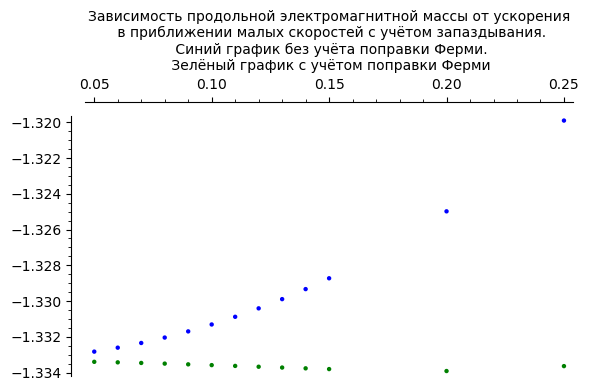

In [31]:
(list_plot(mass_hysteresis_lw_array) + list_plot(mass_hysteresis_fermi_array, color="green")
) .show(title = 
        "Зависимость продольной электромагнитной массы от ускорения\n в приближении малых скоростей с учётом запаздывания.\n"
        " Синий график без учёта поправки Ферми.\n Зелёный график с учётом поправки Ферми")

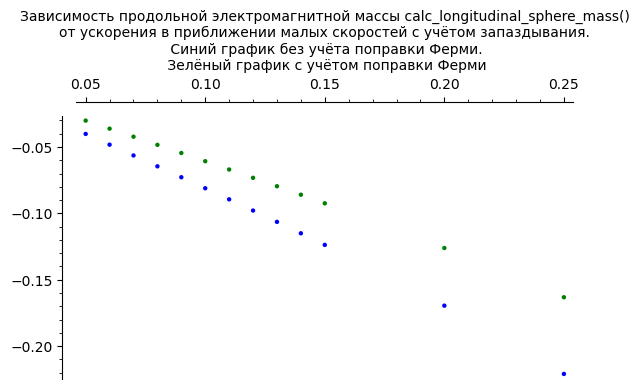

In [32]:
(
    list_plot([[v[0], v[1]] for v in mass_longi_array]) +
    list_plot([[v[0], v[2]] for v in mass_longi_array], color = "green")
) .show(title = 
        "Зависимость продольной электромагнитной массы calc_longitudinal_sphere_mass()\n"
        "от ускорения в приближении малых скоростей с учётом запаздывания.\n"
        " Синий график без учёта поправки Ферми.\n Зелёный график с учётом поправки Ферми")